Importing my libraries

In [4]:
!python -m spacy download en_core_web_md
!python -m spacy download fr_core_news_md
#!pip install cupy

import tarfile
import numpy as np
import spacy
#import cupy as cp
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 23.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
  Using cached https://github.com/explosion/spacy-models/releases/download/fr_core_news_md-3.7.0/fr_core_news_md-3.7.0-py3-none-any.whl (45.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


#Creating helper functions to process the data

In [ ]:


def load_data(file_path):
    with open(file_path, encoding='utf-8') as file:
        lines = [line.strip().lower() for line in file if line.strip()]
    return lines

def preprocess(lang_sentences, percentages, lang_models, device="CPU"):
    # in this preprocess function the data is added such that
    # there is a small randomness added to it for training in the GANS
    # i dont know why i added this but to test it might work like a bias value
    data = []
    if device == "GPU":
      for sentence_0, sentence_1 in zip(*lang_sentences):
          embedded_0 = lang_models[0](sentence_0).vector
          embedded_1 = lang_models[1](sentence_1).vector
          max_len = max(len(embedded_0), len(embedded_1))
          # this is the gpu based code
          pad_embedded_0 = cp.pad(cp.asarray(embedded_0), (0, max_len - len(embedded_0)), 'constant')
          pad_embedded_1 = cp.pad(cp.asarray(embedded_1), (0, max_len - len(embedded_1)), 'constant')
          random_mat = cp.random.rand(*embedded_0.shape)
          full = pad_embedded_0 * percentages[0] + pad_embedded_1 * percentages[1] + random_mat
          data.append(full)
      return cp.array(data)
    else:
      # this is the cpu based code
      for sentence_0, sentence_1 in zip(*lang_sentences):
          embedded_0 = lang_models[0](sentence_0).vector
          embedded_1 = lang_models[1](sentence_1).vector
          max_len = max(len(embedded_0), len(embedded_1))
          # this is the cpu based code
          pad_embedded_0 = np.pad(embedded_0, (0, max_len - len(embedded_0)), 'constant')
          pad_embedded_1 = np.pad(embedded_1, (0, max_len - len(embedded_1)), 'constant')
          random_mat = np.random.rand(*embedded_0.shape)
          full = pad_embedded_0 * percentages[0] + pad_embedded_1 * percentages[1] + random_mat
          data.append(full)
      return np.array(data)

#PreProccessing and creating data

In [ ]:

# Load English and French data
english_sentences = load_data('europarl-v7.fr-en.en')
french_sentences = load_data('europarl-v7.fr-en.fr')

# load the spacy word embeddings for french and english
spacy.require_gpu()
spacy_embedding_en = spacy.load('en_core_web_md')
spacy_embedding_fr = spacy.load('fr_core_news_md')

# **mish mash** with 0.5 and 0.5 percentage points
mashed_sentences = preprocess([english_sentences, french_sentences],
                          [0.5, 0.5],
                          [spacy_embedding_en, spacy_embedding_fr],
                          "GPU")
np.save('mashed_sentences_fr_en_50_50.npy', mashed_sentences) # saving data so doesnt haev to be loaded again
# printing to see what the data looks like
print(english_sentences[0])
print(french_sentences[0])
print(mashed_sentences[0])

resumption of the session
reprise de la session
[-2.49061651  1.11504854  2.39136881  3.79393344  3.69417012  1.24119013
  1.2501395   4.05214932  4.24175742 -1.30667777  5.60183789  2.2270884
 -4.08571278 -0.20129039  1.93792178  2.34961002  3.40335188  1.3221339
  1.54315684 -0.85947136  0.83531318 -0.85715479 -1.59579728  2.56697813
  1.02794241  2.84286097 -0.48122997  2.42148331  0.81854976  4.26659952
 -1.04953354 -0.11484184  1.52995699 -1.27412736 -1.66854097 -0.69063173
  0.90881016  2.80558016 -1.04453607  2.75602544  0.79864483 -0.28106232
 -0.96821351  0.77351036 -1.21005747  1.01178247  1.49607794  0.74820235
  0.25112318  0.06429124 -1.48974746  3.01765381 -0.32320162 -2.58223267
  0.94201671  1.91856262 -0.91353967  1.17046314 -1.25212225 -1.95709339
  1.43476395 -1.39199753 -1.3311984   1.45318164  1.93650032  2.3303438
 -1.97216938 -2.22071507  2.76307478  1.29644412  0.95721379  0.57003767
 -1.58387107 -1.29374905  0.34884804  1.78652949 -1.13213232  5.22314515
 -4.19

#Here after processing the data it can be loaded with pytorch data loader object

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MashedDataset(Dataset):
  def __init__(self, data):
        self.data = data

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
      return self.data[idx]

mashed_sentences = np.load('mashed_sentences_fr_en_50_50.npy')
mashed_sentences_dataset = MashedDataset(torch.from_numpy(mashed_sentences))
# make sure to from numpy it
batch_size = 64
mashed_sentences_data = DataLoader(mashed_sentences_dataset,
                                   batch_size=batch_size,
                                   shuffle=True)

#Here is the onehot outputs for characters and their encodings

In [5]:
one_hot_characters = ['a', 'à','â', 'æ', 'b', 'c', 'ç', 'd', 'e', 'é', 'è', 'ê',
                      'ë', 'œ', 'f', 'g', 'h', 'i', 'î', 'ï', 'j', 'k', 'l',
                      'm', 'n', 'o', 'ô', 'p', 'q', 'r', 's', 't', 'u', 'ù','û',
                      'ü', 'v', 'w', 'x', 'y', 'ÿ' 'z', "'", ' ']
                      # space character and ' included
# this is both english and french characters discluding the overlap
# capitals are **banned** and arent used
# helper dictionaries for conversions
char_to_index = {char: index for index, char in enumerate(one_hot_characters)}
index_to_char = {index: char for index, char in enumerate(one_hot_characters)}


#Generator Architecture

The way this works is it will take in some length vector and then from it it will create the one hot matrix which represents the generated mish mashed sentence


In [21]:
class Generator(nn.Module):
    def __init__(self, input_size=100, seq_length=60):
        super(Generator, self).__init__()
        self.seq_length = seq_length
        self.gru = nn.GRU(input_size, 256, num_layers=1, batch_first=True)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(256, len(one_hot_characters))
        self.softmax = nn.Softmax(dim=2)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.GRU):
                nn.init.xavier_uniform_(m.weight_ih_l0)
                nn.init.xavier_uniform_(m.weight_hh_l0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x, temperature=1.0):
    # Repeat the input noise vector seq_length times to create a sequence
      x = x.repeat(1, self.seq_length, 1)
      out, _ = self.gru(x)  # Only take the output, ignore the hidden state
      out = self.relu(out)
      out = self.linear(out)
      out = out / temperature  # Apply the temperature parameter
      out = self.softmax(out)
      return out


#Call the generator to see what it outputs untrained

In [26]:

def generate_sequence(generator, noise):
    # Generate a sequence of one-hot vectors
    one_hot_sequence = generator(noise, 1000)
    # Convert the one-hot vectors to character indices
    char_indices = torch.argmax(one_hot_sequence, dim=2)
    # Convert the character indices to characters
    sequence = ''.join(index_to_char[index.item()] for index in char_indices[0])
    return sequence

noise = torch.randn(1, 100)
generator = Generator()
sequence = generate_sequence(generator, noise)
print(sequence)

# ill embed this into english and then french and combine it to see what should
# happen from it

spacy_embedding_en = spacy.load('en_core_web_md')
spacy_embedding_fr = spacy.load('fr_core_news_md')

sequence_fr_embedding = spacy_embedding_fr(sequence).vector
sequence_en_embedding = spacy_embedding_en(sequence).vector
mashed_embedding = sequence_fr_embedding * 0.5 + sequence_en_embedding * 0.5
print(mashed_embedding) # this might work
# otherwise some other embedding scheme needs to be defined for the mashed language


ççççççççüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüüü
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#Discriminator Architecture

This has to figure out if something is real or fake

In [28]:
class Discriminator(nn.Module):
    def __init__(self, input_size=256, hidden_size=128):
        super(Discriminator, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=1, batch_first=True)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.gru(x)  # Only take the output, ignore the hidden state
        out = self.relu(out)
        out = self.linear(out[:, -1, :])  # Only take the last output of the sequence
        out = self.sigmoid(out)
        return out


#Testing the untrained discriminator on the previous embeddings

In [31]:
# Convert the numpy array to a PyTorch tensor
mashed_embedding = torch.from_numpy(mashed_embedding)

# Add an extra dimension for the batch size and sequence length if necessary
if len(mashed_embedding.shape) == 1:
    mashed_embedding = mashed_embedding.view(1, 1, -1)

# Instantiate the discriminator
discriminator = Discriminator(input_size=mashed_embedding.shape[-1])

# Pass the embeddings through the discriminator
prob = discriminator(mashed_embedding)

print(prob.item())


tensor([[0.4920]], grad_fn=<SigmoidBackward0>)


#Training Setup

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)
# shoving hopefully everything to the gpu

max_epoch = 50 # going for 50 epochs
step = 0 # step through the data
n_noise = 100 # size of noise vector

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=10e-4, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=10e-4, betas=(0.5, 0.999))
# optimizers for both the discriminator and generator alongside a
# binary cross entropy loss

# We will denote real images as 1s and fake images as 0s
# This is why we needed to drop the last batch of the data loader
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake

#Training Loop

In [ ]:
import matplotlib.pyplot as plt
# import pyplot to plot images

for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x) # input includes labels
        D_x_loss = criterion(x_outputs, D_labels) # Discriminator loss for real images

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z)) # input to both generator and discriminator includes labels
        D_z_loss = criterion(z_outputs, D_fakes) # Discriminator loss for fake images
        D_loss = D_x_loss + D_z_loss # Total Discriminator loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()
        # updating the discriminator model

        # Training Generator
        z = torch.randn(batch_size, n_noise).to(DEVICE) # creating the random vector alongside the batch proper
        z_outputs = D(G(z))
        G_loss = -1 * criterion(z_outputs, D_fakes) # Generator loss is negative disciminator loss

        G.zero_grad()
        G_loss.backward()
        G_opt.step()
        # updating the generator model

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
            # done to view teh loss
        step += 1

    if epoch+1 in [1, 10, 30, 50]:
      # if in the 1st (done for making sure everything is good)
      # or the 10th or 30th or 50th epoch then display what the
      # generator has so far
      G.eval()  # eval mode
      img = get_sample_image(G, DEVICE, n_noise)
      print("got images")
      plt.imshow(img, cmap='gray')
      plt.show()
      # show the plot from get sample images
      G.train()
      # back to trianing the genrator



1/1 [==============================] - 0s 15ms/step
Epoch 100/1000 [D loss: 2.427980661392212, acc.: 50.0] [G loss: 0.017235977575182915]
1/1 [==============================] - 0s 29ms/step
Epoch 200/1000 [D loss: 0.3459985852241516, acc.: 100.0] [G loss: 0.7180488705635071]
1/1 [==============================] - 0s 19ms/step
Epoch 300/1000 [D loss: 0.6472909450531006, acc.: 50.0] [G loss: 0.36351633071899414]
1/1 [==============================] - 0s 17ms/step
Epoch 400/1000 [D loss: 0.7177719473838806, acc.: 50.0] [G loss: 0.3367061913013458]
1/1 [==============================] - 0s 26ms/step
Epoch 500/1000 [D loss: 0.6133091449737549, acc.: 50.0] [G loss: 0.46426188945770264]
1/1 [==============================] - 0s 17ms/step
Epoch 600/1000 [D loss: 0.5504212379455566, acc.: 50.0] [G loss: 0.5941251516342163]
1/1 [==============================] - 0s 31ms/step
Epoch 700/1000 [D loss: 0.3202908933162689, acc.: 100.0] [G loss: 0.7495474219322205]
1/1 [==============================]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


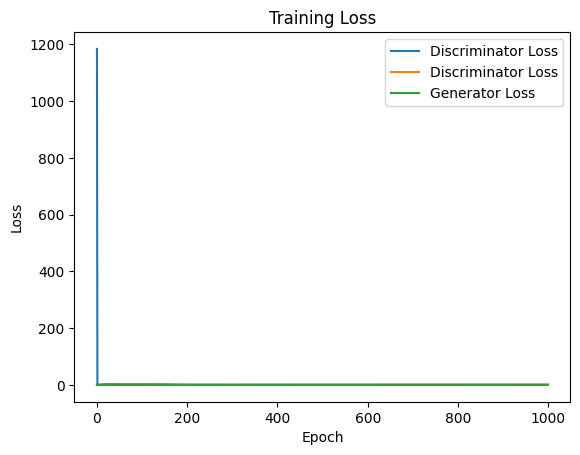

In [ ]:
# Save the model
gan.generator.save('generator_model.h5')
gan.discriminator.save('discriminator_model.h5')

# Plotting the training progress (you need to modify the training loop to store loss values)
plt.plot(discriminator_loss, label='Discriminator Loss')
plt.plot(generator_loss, label='Generator Loss')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
def generate_text(generator, tokenizer, latent_dim, num_sentences):
    # Generate noise.
    noise = np.random.normal(0, 1, (num_sentences, latent_dim))
    # Generate token indices from the noise using the generator.
    generated_sequences = generator.predict(noise)
    # Convert the output probabilities to token indices.
    generated_sequences = np.argmax(generated_sequences, axis=-1)

    # Initialize an empty list to hold the generated sentences.
    text_batch = []

    # Process each sequence to convert token indices to words.
    for seq in generated_sequences:
        # Filter out zeros (unwanted tokens) from the sequence.
        filtered_indices = seq[seq != 0]
        # Convert non-zero indices to words using the tokenizer.
        words = [tokenizer.index_word.get(i, '') for i in filtered_indices]
        # Join the words to form a sentence.
        sentence = ' '.join(words).strip()
        # Add the sentence to the batch of generated text.
        text_batch.append(sentence)

    return text_batch

# Example usage of the function to generate text.
generated_text = generate_text(gan.generator, tokenizer, latent_dim=100, num_sentences=15)
for text in generated_text:
    print(text)


1/1 [==============================] - 0s 19ms/step
nous
nous
nous
nous
nous
nous
nous
nous
nous
nous
nous
nous
nous
nous
nous
